# Random Forest Classifier 

In this notebook, we will implement a random forest model to classify success/failure of terrorist attacks in our database. Our goal is to find out how accurate this model is compared to LASSO regression and a neural network. 

## Benefits 

1. **Interpretability**: Unlike neural networks, whose behavior tends to be opaque, a decision tree is easily interpretable by humans. This is important for counterterrorism applications, since prediction is only an instrumental goal. The ultimate use of our project is to inform decision-makers about *what makes an attack successful.* Therefore, examining what features the decision trees in our model tend to split on is key to dispensing actionable advice to key actors, such as "weapon type is more important than target type."

2. **Ensemble modeling**: A random forest takes a weighted vote amongst various individual decision-tree classifiers, creating more robustness and allowing for hyperparamter optimization in the form of number of trees. 

3. **Binary classification**: Decision trees are well-suited to binary classification problems, which is the kind that we are trying to solve. 

## Preprocessing

First, we'll load the data and separate it into training and test sets.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from preprocess_functions import load_data_relevant_cols, get_dummies
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
np.random.seed(159)

In [6]:
raw.columns.values

array(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1', 'attacktype1_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'natlty1', 'natlty1_txt', 'gname', 'motive', 'weaptype1',
       'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'nkill',
       'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property',
       'propextent', 'propextent_txt', 'propvalue', 'propcomment',
       'ransom', 'ransomamt'], dtype=object)

In [44]:
categorical_features = ['country_txt', 'region_txt', 'attacktype1_txt', 'targtype1_txt', 
                     'targsubtype1_txt', 'natlty1_txt', 'weaptype1_txt', 'weapsubtype1_txt']
numerical_features = ['nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte',
                      'iyear', 'success']
one_hot_X = get_dummies(raw, categorical_features)
numeric_data = raw[numerical_features]
all_data = one_hot_X.join(numeric_data).dropna()

In [45]:
y_labels = all_data['success']
x_data = all_data.drop(columns=['success'])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.1, random_state=42)

## Grid Search

There are several hyperparameters in a random forest model which we can adjust. However, due to computational limitations, we choose to only optimize two: 

1. **Maximum Depth**: This refers to the maximum allowable depth of each decision tree in the forest. Without a maximum depth, the trees would overfit by splitting until achieving perfect training accuracy. Therefore, it is important to keep maximum depth relatively small to avoid overfitting. 

2. **Number of estimators**: This refers to the number of decision trees in the forest. Presumably an increase in the number of trees increases robustness of the model. However, there is likely a point of diminishing marginal returns and perhaps even loss of test accuracy. 

For an impurity metric on splits, we chose the Gini Index. While we could have optimized between this metric and information gain, this would have doubled the runtime of our grid search and would have likely yield no significant improvement. According to [research on the differences of these two methods](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf), they disagree in only 2 percent of cases. 

In [86]:
forest_hyperparams = {'max_depth': np.arange(6, 11), 
                      'n_estimators': np.arange(6, 11)}
generic_model = RandomForestClassifier(criterion='gini', max_features=None, random_state=159)   
grid_searcher = GridSearchCV(generic_model, forest_hyperparams, return_train_score=False)

In [87]:
#warning: this cell will take about 10 minutes to run.
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=159, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 6,  7,  8,  9, 10]), 'n_estimators': array([ 6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [93]:
grid_searcher.best_params_

{'max_depth': 10, 'n_estimators': 7}

In [94]:
grid_searcher.best_score_

0.92837436703335074

### Discussion

The results of our grid search have found that the best parameter configuration is a maximum depth of 10, with 7 estimators. This yields a test accuracy of 92.8%. Notably, we expected a larger number of estimators and small depth to have the best performance - but the opposite is true. This shows the importance of empirically optimizing one's hyperparameters whenever possible, as opposed to picking whatever model seems best at the time. 

### Visualization

Next, we'll visualize the test accuracy of our hyperparameter configurations. 

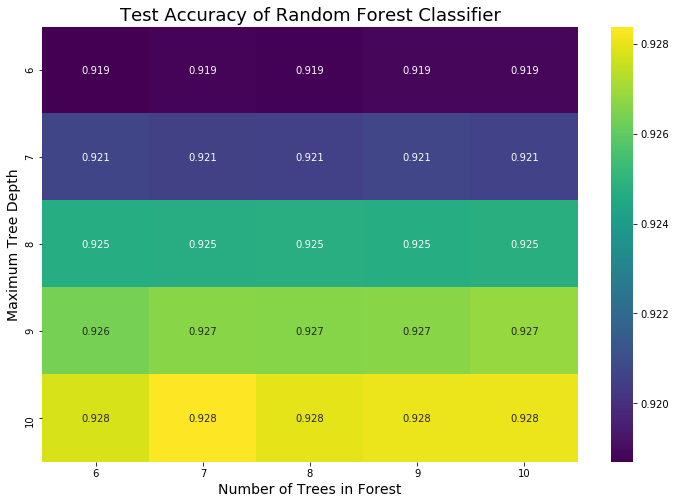

In [147]:
mean_test_scores = grid_searcher.cv_results_['mean_test_score'].reshape(5, 5)

plt.figure(figsize=(12, 8))
sns.heatmap(mean_test_scores, xticklabels=np.arange(6, 11), 
            yticklabels=np.arange(6, 11), annot=True, cmap='viridis', fmt='.3g')
plt.xlabel('Number of Trees in Forest', fontsize=14)
plt.ylabel('Maximum Tree Depth', fontsize=14)
plt.title('Test Accuracy of Random Forest Classifier', fontsize=18)
plt.savefig('random_forest_hyperparams_heatmap.png')
plt.show();